In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import scipy.optimize
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def split_border(Nodes,N,closed=False):
    points_x = np.array([])
    points_y = np.array([])
    for i in range(Nodes.shape[0]-2):
        points_x = np.append(points_x, np.linspace(Nodes[i,0],Nodes[i+1,0],N[i])[:-1])
        points_y = np.append(points_y,np.linspace(Nodes[i,1],Nodes[i+1,1],N[i])[:-1])
        
    if not closed:   
        points_x = np.append(points_x,np.linspace(Nodes[-2,0],Nodes[-1,0],N[-1]))
        points_y = np.append(points_y,np.linspace(Nodes[-2,1],Nodes[-1,1],N[-1]))
    if closed:
        points_x = np.append(points_x,np.linspace(Nodes[-2,0],Nodes[-1,0],N[-1])[:-1])
        points_y = np.append(points_y,np.linspace(Nodes[-2,1],Nodes[-1,1],N[-1])[:-1])
    
    
    return np.hstack((points_x.reshape(-1,1),points_y.reshape(-1,1)) )

In [3]:
def create_arc(c,r,a1,a2,s):
    alpha = np.radians(np.linspace(a1,a2,s))
    x = r*np.cos(alpha) + c[0]
    y = r*np.sin(alpha) + c[1]
    
    return np.hstack((x.reshape(-1,1),y.reshape(-1,1)) )

In [4]:
def tilt_square_vert(c,w):
    dd = np.sqrt(2.)/2.
    L_out = w
    points_delta = np.array([[0,dd*L_out],
                           [dd*L_out,0],
                           [0,-dd*L_out],
                           [-dd*L_out,0]])
    points_out = np.tile(c,(4,1))+points_delta

    return points_out    

In [5]:
def create_rounded_square(points,R,s_arc,s_line,mask_data = True):
    dd = np.sqrt(2)
    deltas = np.array([[0,-dd*R],
                       [-dd*R,0],
                       [0,dd*R],
                       [dd*R,0]])
    centers = points + deltas
    angles = np.array([[135.,45.],
                       [45.,-45.],
                       [-45.,-135.],
                       [225.,135.]])
    
    arcs = []
    for c, a in zip(centers,angles):
        arcs.append(create_arc(c,R,a[0],a[1],s_arc))
    lines = []
    for i in range(len(arcs)-1):
        lines.append(split_border(np.array([arcs[i][-1],arcs[i+1][0]]),[s_line])[1:-1])
        #lines.append(np.linspace(arcs[i][-1],arcs[i+1][0],s_line)[1:-1])
    lines.append(split_border(np.array([arcs[-1][-1],arcs[0][0]]),[s_line])[1:-1])
    rez = np.vstack((arcs[0],lines[0],arcs[1],lines[1],arcs[2],lines[2],arcs[3],lines[3]))
    if mask_data:
        arcs = np.array(arcs)
        rect1 = np.hstack((arcs[[0,2],-1,:],arcs[[1,3],0,:])).reshape(-1,2)
        rect2 = np.hstack((arcs[[0,2],0,:],arcs[[1,3],-1,:])).reshape(-1,2)
        return centers, rect1, rect2, rez 
    return rez

In [6]:
def enclose(points):
    return np.vstack((points,points[0]))

In [58]:
def create_fig(L,W):
    #import pdb;pdb.set_trace()
    L_out = 150
    s_out = [60]*4
    c1 = np.array([0,0])
    points_out = tilt_square_vert(c1,L_out)
    nodes_out = split_border(enclose(points_out),s_out,closed=True)
    
    points_left = tilt_square_vert(c1+[-L/2,0],W)
    points_right = tilt_square_vert(c1+[L/2,0],W)
    R1 = 10
    k1 = 0.1
    k2 = 0.2
    centers1,rect11,rect12,nodes_left = create_rounded_square(points_left,R1,int(2*np.pi*R1*k2),int(4*W*k1))
    centers2,rect21,rect22,nodes_right = create_rounded_square(points_right,R1,int(2*np.pi*R1*k2),int(4*W*k1))
    s_mesh = 65
    delta = 1
    X,Y = np.meshgrid(np.linspace(-L_out/2+delta,L_out/2-delta,s_mesh),np.linspace(-L_out/2+delta,L_out/2-delta,s_mesh))
    RotRad = np.pi/4.
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                      [-np.sin(RotRad), np.cos(RotRad)]])
    X1,Y1 = np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([X, Y]))
    del X,Y
    inner = np.vstack((X1.ravel(),Y1.ravel())).T
    '''
    masks_rect = [True]*inner.shape[0]
    for rect in [rect11,rect12,rect21,rect22]:
        masks_rect = masks_rect & np.logical_not(in_rect(rect,delta,inner))
    masks_circ = [True]*inner.shape[0]
    for center in np.vstack((centers1,centers2)):
        masks_circ = masks_circ & np.logical_not(in_circle(inner,center,R1,delta))
    inner = inner[masks_rect & masks_circ]
    '''
    
    mask1 = not_in_sq_rect([rect11,rect12],centers1,0.8,R1,inner)
    mask2 = not_in_sq_rect([rect21,rect22],centers2,0.8,R1,inner)
    inner = inner [mask1 & mask2]
    Nodes = np.vstack((nodes_out,nodes_left,nodes_right,inner))
    simplices = scipy.spatial.Delaunay(Nodes).simplices
    trng_centers = np.hstack((np.mean(Nodes[simplices][:,:,0],axis=1).reshape(-1,1),
                              np.mean(Nodes[simplices][:,:,1],axis=1).reshape(-1,1)))
    mask3 = not_in_sq_rect([rect11,rect12],centers1,0.0,R1,trng_centers)
    mask4 = not_in_sq_rect([rect21,rect22],centers2,0.0,R1,trng_centers)
    simplices = simplices[mask3 & mask4]
    return Nodes, simplices

In [8]:
def show_parts(*parts):
    plt.figure(figsize=(14,14))
    plt.grid(True)
    
    for part in parts:
        plt.plot(part[:,0],part[:,1],'.',c='b',markersize=3)
    plt.axis('equal')

In [9]:
def line(p1,p2,x):
    return p1[1]+(p2[1]-p1[1])*((x-p1[0])/(p2[0]-p1[0]))

In [25]:
def in_rect(rect,k,arr):
    gn1 = line(rect[0],rect[1],arr[:,0])>arr[:,1]+np.full_like(arr[:,1],-k)
    gn2 = line(rect[1],rect[2],arr[:,0])<arr[:,1]+np.full_like(arr[:,1],k)
    gn3 = line(rect[2],rect[3],arr[:,0])<arr[:,1]+np.full_like(arr[:,1],k)
    gn4 = line(rect[3],rect[0],arr[:,0])>arr[:,1]+np.full_like(arr[:,1],-k)
    return gn1 & gn2 & gn3 & gn4

In [36]:
def in_circle(inner, circ_center, radius,delta):
    mask = np.sum(np.power(inner - circ_center, 2), axis=1) < np.power(radius+delta, 2)
    return mask

In [52]:
def not_in_sq_rect(rects,cents,delta,r,arr):
    masks_rect = [True]*arr.shape[0]
    for rect in rects:
        masks_rect = masks_rect & np.logical_not(in_rect(rect,delta,arr))
    masks_circ = [True]*arr.shape[0]
    for center in cents:
        masks_circ = masks_circ & np.logical_not(in_circle(arr,center,r,delta))
    return masks_rect & masks_circ

In [59]:
ar1, sr1 = create_fig(80,35)

(-116.67261889578035,
 116.67261889578035,
 -116.67261889578035,
 116.67261889578035)

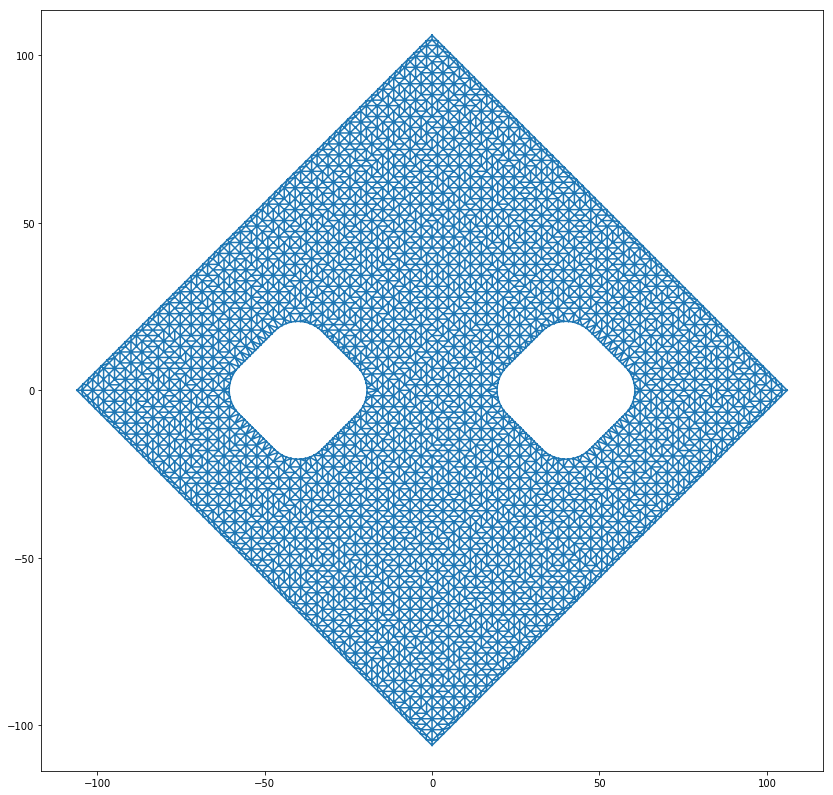

In [60]:
plt.figure(figsize=(14,14))
plt.triplot(ar1[:,0],ar1[:,1],sr1)
plt.axis('equal')

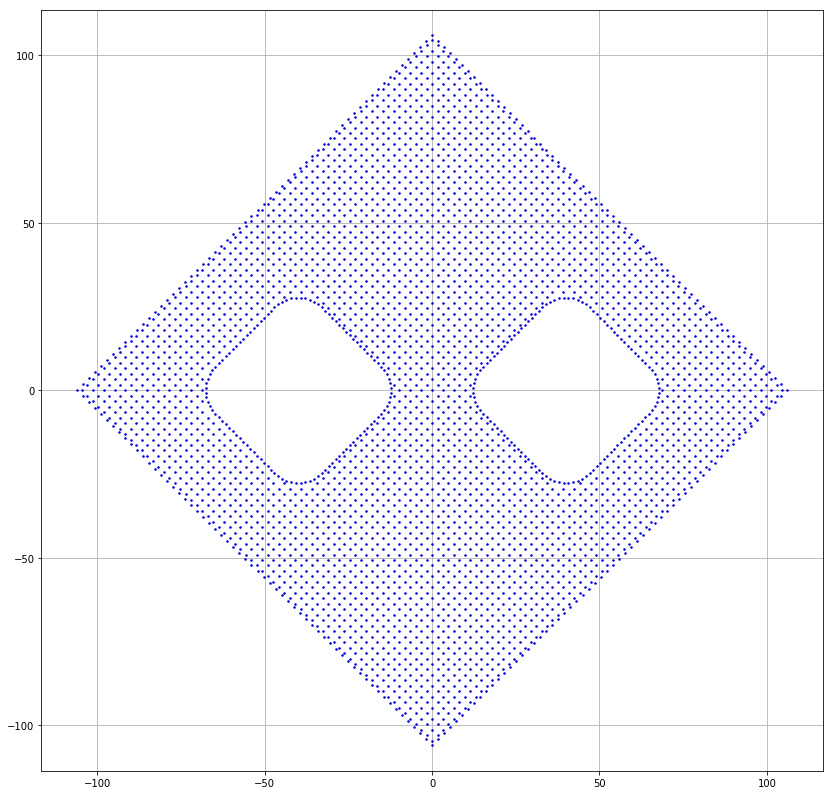

In [41]:
show_parts(ar1)
#plt.plot(rr1[:,0],rr1[:,1],'xr')
#plt.plot(rr2[:,0],rr2[:,1],'xr')
#plt.plot(rr1[0][0],rr1[0][1],'xr')
#plt.plot(rr1[1][0],rr1[1][1],'xr')

In [61]:
line(rr1[0],rr1[1],0)

-18.786796564403573

In [60]:
len(ar1)

4637

In [62]:
ar1.shape

(4637, 2)

In [59]:
len(line(rr1[0],rr1[1],ar1[:,0]))

4637

In [130]:
np.logical_not(in_rect(rr1,0,ar1))

array([ True,  True,  True, ...,  True,  True,  True])

In [138]:
np.logical_not(in_rect(rr1,0,ar1)).shape

(4637,)

In [136]:
np.logical_not(in_rect(rr2,0,ar1))

array([ True,  True,  True, ...,  True,  True,  True])

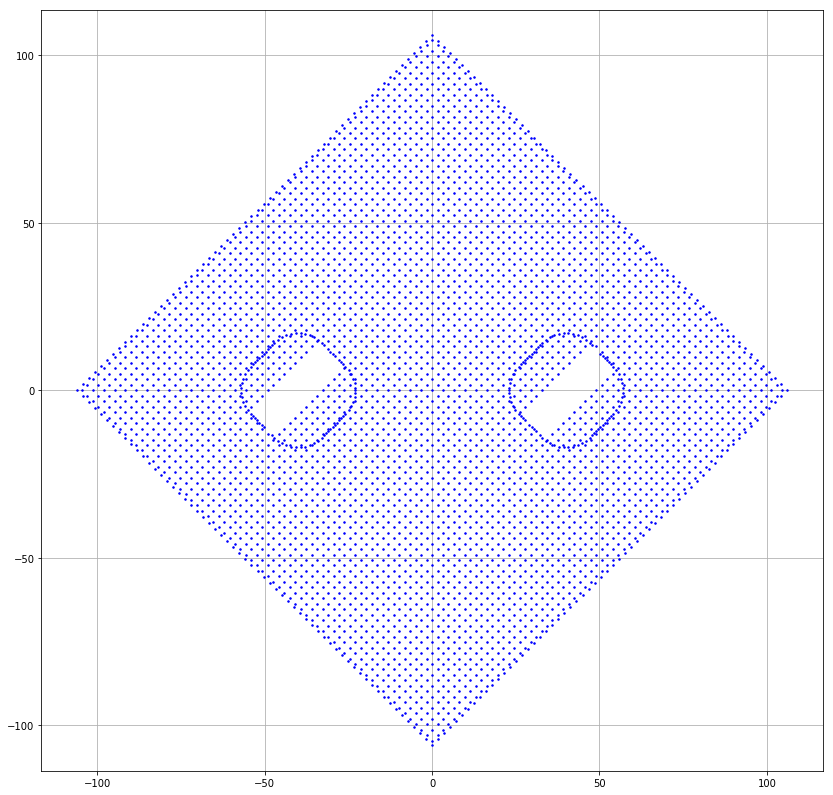

In [137]:
show_parts(ar1[np.logical_not(in_rect(rr1,0,ar1)) & np.logical_not(in_rect(rr2,0,ar1))])

In [103]:
gn1 = line(rr1[0],rr1[1],ar1[:,0])>ar1[:,1]+np.full_like(ar1[:,1],0.1)

In [104]:
gn2 = line(rr1[1],rr1[2],ar1[:,0])<ar1[:,1]+np.full_like(ar1[:,1],-0.1)

In [105]:
gn3 = line(rr1[2],rr1[3],ar1[:,0])<ar1[:,1]+np.full_like(ar1[:,1],-0.1)

In [107]:
gn4 = line(rr1[3],rr1[0],ar1[:,0])>ar1[:,1]+np.full_like(ar1[:,1],0.1)

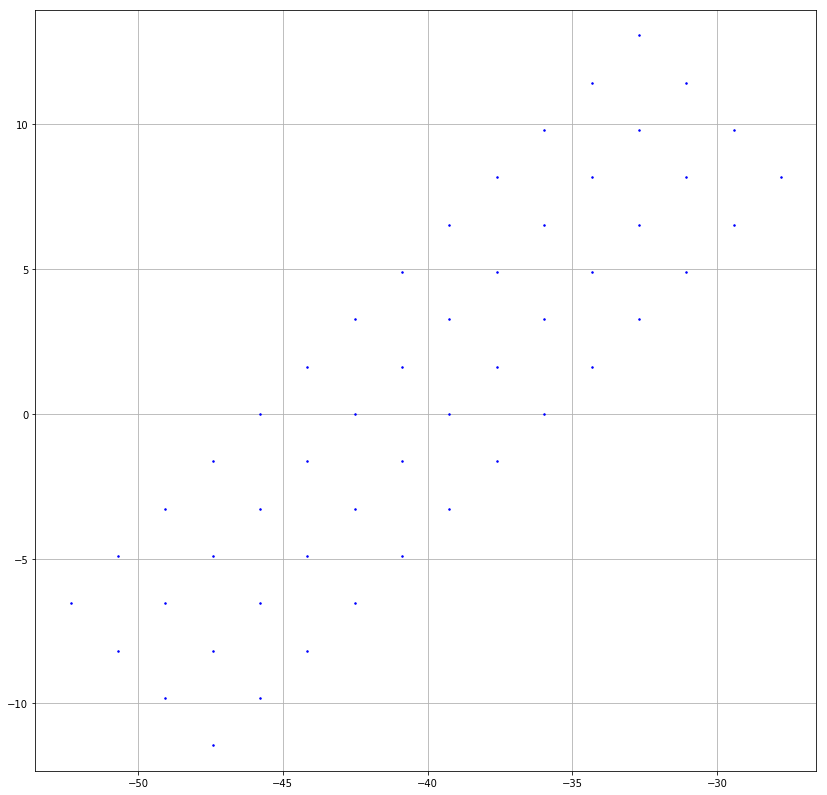

In [108]:
show_parts(ar1[gn1 & gn2 & gn3 & gn4])

In [20]:
temp = np.array([[[1,2],[3,4],[5,6]],[[7,8],[9,10],[11,12]],[[13,14],[15,16],[17,18]],[[19,20],[21,22],[23,24]]])
temp

array([[[ 1,  2],
        [ 3,  4],
        [ 5,  6]],

       [[ 7,  8],
        [ 9, 10],
        [11, 12]],

       [[13, 14],
        [15, 16],
        [17, 18]],

       [[19, 20],
        [21, 22],
        [23, 24]]])

In [36]:
v1 = temp[[0,2],-1,:]

In [35]:
v2 = temp[[1,3],0,:]

In [39]:
np.hstack((v1,v2)).reshape(-1,2)

array([[ 5,  6],
       [ 7,  8],
       [17, 18],
       [19, 20]])

In [19]:
temp.shape

(4, 3, 2)

In [243]:
!pwd

/home/alex/ISM


In [227]:
X,Y = np.meshgrid(np.linspace(-150,150,150),np.linspace(-150,150,150))
#inner = np.vstack((X.ravel(),Y.ravel())).T

In [228]:
RotRad = np.pi/4.

In [229]:
RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                      [-np.sin(RotRad), np.cos(RotRad)]])

In [230]:
X1,Y1 = np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([X, Y]))

In [231]:
inner = np.vstack((X1.ravel(),Y1.ravel())).T

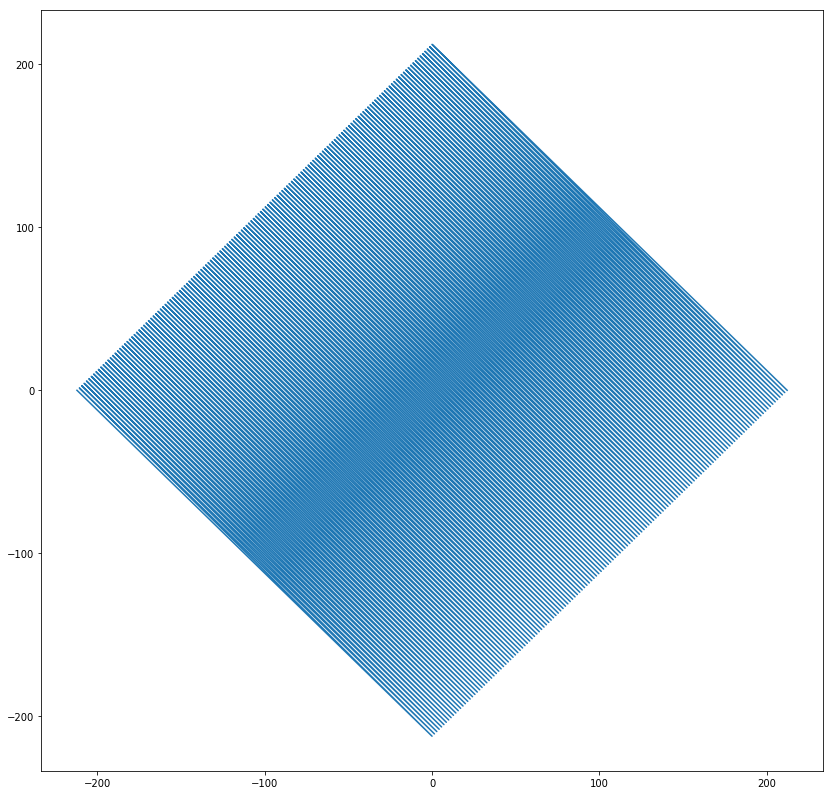

In [232]:
plt.figure(figsize=(14,14))
plt.plot(inner[:,0],inner[:,1])

In [248]:
tt1 = tilt_square_vert([0,0],25)
ar1 = create_rounded_square(tt1,10,20,20)

(-14.879690638786323,
 14.879690638786323,
 -14.879690638786323,
 14.879690638786323)

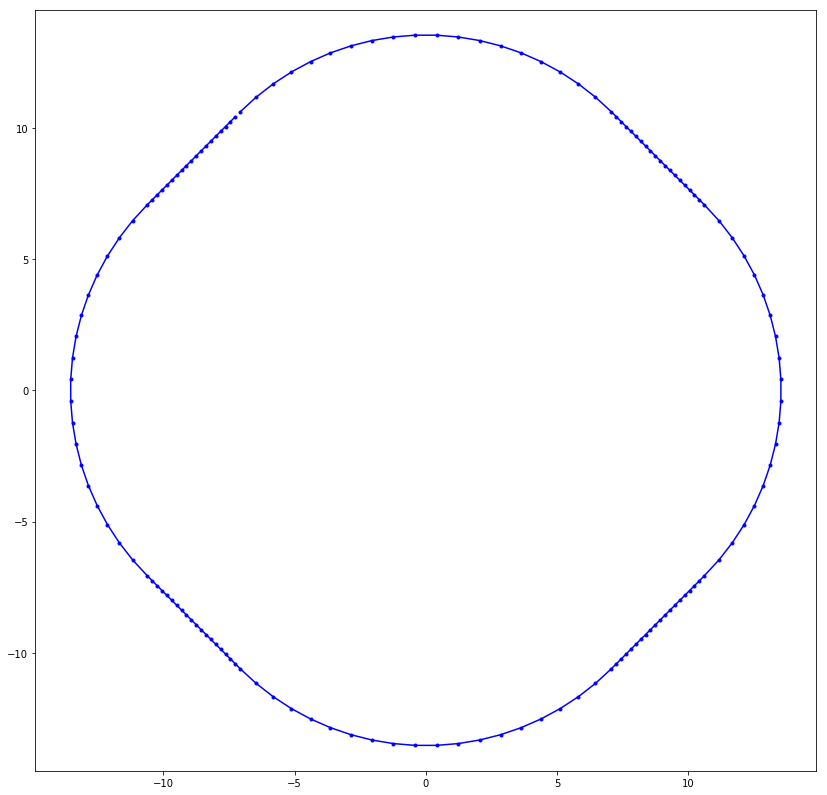

In [251]:
plt.figure(figsize=(14,14))
plt.plot(ar1[:,0],ar1[:,1],'.-',c='b')
#for i, p in enumerate(ar1):
#    plt.text(p[0], p[1], ' %d'%i)
plt.axis('equal')